# Pneumonia image classification

### Transfer Learning - VGG16 Model

Supervised learning using convolutional neural network (CNN) to detect the presence of pneumonia from chest X-ray images.

The common procedures of implementing neural networks using TensorFlow are:

- Data preparation
- Model definition
- Model training
- Model evaluation
- Model application
- Model saving

####  Basic machine learning workflow:

- Examine and understand data (EDA)
- Build an input pipeline
- Build the model
- Train the model
- Test the model
- Improve the model and repeat the process


# Import packages

In [1]:
# importing libraries
import os
import warnings
from math import ceil
import pandas as pd
import numpy as np
from numpy.random import seed
import random
import copy
import cv2
import albumentations as A
import shutil
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
print("[INFO] All packages are ready...")


[INFO] All packages are ready...


In [2]:
# check TF vesion
print("Tensorflow version: ", tf.__version__)

# check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

if len(physical_devices) == 0:
    print("GPU device not found. Running on CPU.")
else:
    print('Found GPU at: {}'.format(physical_devices))


Tensorflow version:  2.6.0
Num GPUs: 1
Found GPU at: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Reproducibility


def set_seed(seed=123):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(123)

# matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold',
       labelsize='large',
       titleweight='bold',
       titlesize=18,
       titlepad=10)

print("[INFO] Reproducibility and plot settings set up.")


[INFO] Reproducibility and plot settings set up.


### Mount google drive

In [4]:
# mount google drive
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set working directory

In [5]:
import sys

# set working directory for google colab
path = '/content/drive/MyDrive/Colab Notebooks'
sys.path.insert(0, path)
print("[INFO]  Working directory path is set up...")


[INFO]  Working directory path is set up...


## Download dataset and unzipped it

In [6]:
# download data from kaggle api
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d "tolgadincer/labeled-chest-xray-images" -p "~/workspace/ml-apps/input/"


In [ ]:
from utils.unzip_file import unzip_file

# path where our data resides
file_path = '/content/drive/MyDrive/input/chest_xray.zip'

unzip_file(file_path)
print("[INFO]  Data has been unzipped...")


# Load Data

In [8]:
# set data directories
BASE_DIR = "/content/"
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# look into train folder for .jpg files for normal and pneumonia images
NORMAL_IMAGES = os.path.join(BASE_DIR, "train/NORMAL/")
PNEUMONIA_IMAGES = os.path.join(BASE_DIR, "train/PNEUMONIA/")

print("Data is ready.")


Data is ready.


# Exploratory Data Analysis

First let's check the training dataset. We will do some analysis on that, look at some of the samples, check the number of samples for each class.

Each of the above directory contains two sub-directories:

- NORMAL: These are the samples that describe the normal (no pneumonia) case.
- PNEUMONIA: This directory contains those samples that are the pneumonia cases.

Things to take in consideration:

- Image size and format
- Image clarity (bright, constrast, etc...)
- Image noise (medical equipment, marks, etc ...)
- Quality of captured images

An important thing to note:
- The diagnosed has to be done by a specialized professional


### Check number of train and test images

In [9]:
# create two functions to check the total number of train/test images


def count_train_data():
    input_normal_train_files = os.listdir(os.path.join(BASE_DIR,
                                          "train/NORMAL"))
    print(f"Number of train normal images: {len(input_normal_train_files)}")
    input_pneumonia_train_files = os.listdir(os.path.join(BASE_DIR,
                                             "train/PNEUMONIA"))
    print(
        f"Number of train pneumonia images: \
         {len(input_pneumonia_train_files)}"
    )
    print(
        "Total number of training images:",
        len(input_normal_train_files) + len(input_pneumonia_train_files),
    )


def count_test_data():
    input_normal_test_files = os.listdir(os.path.join(BASE_DIR, "test/NORMAL"))
    print(f"Normal images in training set: {len(input_normal_test_files)}")

    input_pneumonia_test_files = os.listdir(os.path.join(BASE_DIR,
                                            "test/PNEUMONIA"))
    print(
        f"Pneumonia images in training set:  \
         {len(input_pneumonia_test_files)}"
    )
    print(
        "Total number of testing images:",
        len(input_normal_test_files) + len(input_pneumonia_test_files),
    )


count_train_data()
print("")
count_test_data()


Number of train normal images: 1349
Number of train pneumonia images:          3883
Total number of training images: 5232

Normal images in training set: 234
Pneumonia images in training set:           390
Total number of testing images: 624


Notice that the there are way more images that are classified as pneumonia than normal. This shows that we have a imbalance in our data.


In [10]:
# check the class names
class_names = np.array(
    [
        str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
        for item in tf.io.gfile.glob(str(BASE_DIR + "/train/*"))
    ]
)

# print our classes names
class_names


array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

As we can see in the output, the dtype of the given numpy array object is '<U9' where 9 is the length of the longest string in the given array object. 

In [11]:
# let's check how many pneumonia vs normal cases we have
sets = ["train", "test"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(BASE_DIR, cat)
    norm = glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")


Total Pneumonia Images: 4273
Total Normal Images: 1583


### Create a dataframe of all the images

In [12]:
# Get the list of all the images
normal_cases = glob(os.path.join(TRAIN_DIR, "NORMAL/*.jpeg"))
pneumonia_cases = glob(os.path.join(TRAIN_DIR, "PNEUMONIA/*.jpeg"))

# An empty list. We will insert the data into this list in
# (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img, 0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=["image", "label"], index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.0).reset_index(drop=True)

# show dataframe
print(train_data.shape)
train_data.info()
print("Training dataset")
train_data.head()


(5232, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5232 non-null   object
 1   label   5232 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.9+ KB
Training dataset


image  label
0  /content/train/PNEUMONIA/BACTERIA-4617189-0008...      1
1  /content/train/PNEUMONIA/BACTERIA-7599671-0001...      1
2     /content/train/NORMAL/NORMAL-4486854-0001.jpeg      0
3   /content/train/PNEUMONIA/VIRUS-6721427-0001.jpeg      1
4  /content/train/PNEUMONIA/BACTERIA-8047963-0004...      1

### plot normal vs pneumonia cases

1    3883
0    1349
Name: label, dtype: int64


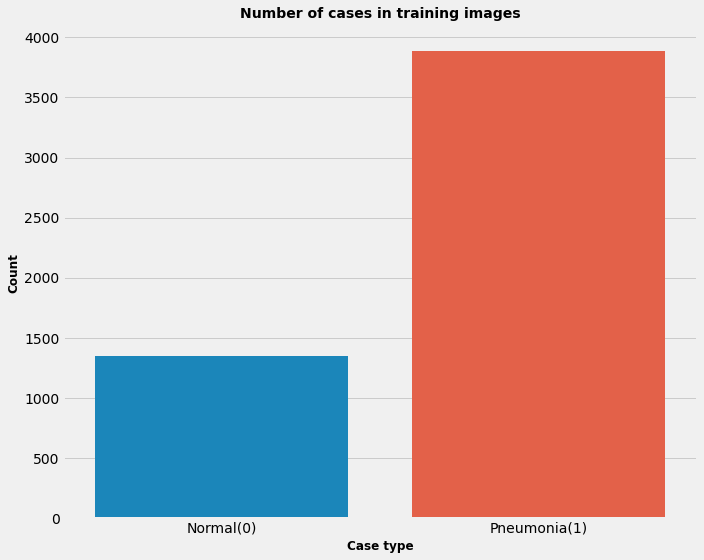

In [13]:
# Get the counts for each train class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases in training images', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)),
           ['Normal(0)', 'Pneumonia(1)'])

plt.show();


As you can see the data is highly imbalanced.  We have almost twice more pneumonia cases compared to the normal cases. However, this situation is very normal when it comes to medical data. The data will always be imbalanced.  Either there will be too many normal cases or there will be too many cases with the disease.

Let's look at how a normal case is different from that of a pneumonia case. We will look at somes samples from our training data itself.  We will leave the testing data alone to prevent data leakage.


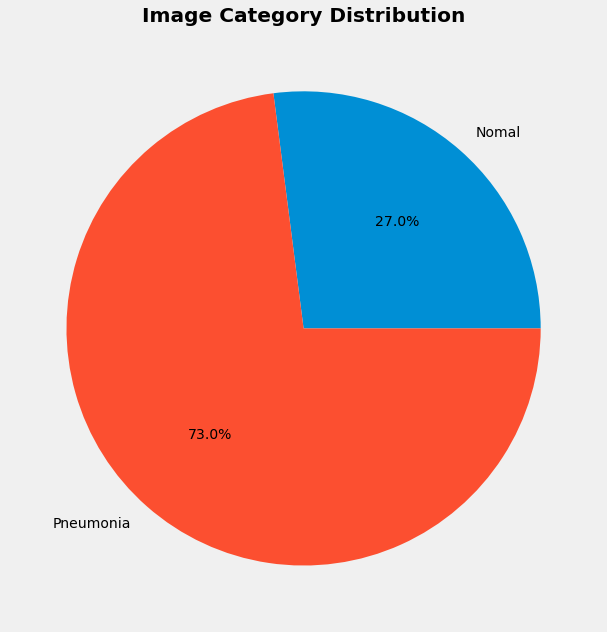

In [14]:
# get the classes labels names and count it
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

# create a pie plot to see the percentage distribution
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show();


We can confirm there's some good data imbalanced. Pneumonia images result in a vast 73% of cases and for normal images only a 27% of cases.  Question to ask here is to see how we can handle this data imbalanced and if it would decrease model performance.  However, in this case it is more convenient to choose different metric than just accuracy.

### Raw Comparison of images

First, we can start by simply looking at a few randomly sampled images of normal and pneumonia.  Let's see what they look like.

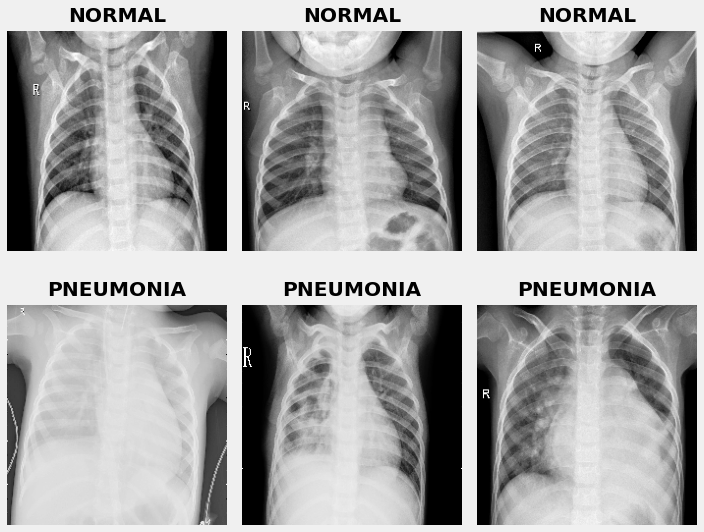

(1349, 3883)

In [15]:
# This step will pull random images from each sub-folders and display them
# get the list of jpegs from sub image class folders
normal_imgs = [
    fn for fn in os.listdir(f"{BASE_DIR}/train/NORMAL") if fn.endswith(".jpeg")
]

pneumo_imgs = [
    fn for fn in os.listdir(f"{BASE_DIR}/train/PNEUMONIA")
    if fn.endswith(".jpeg")
]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace=False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace=False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize=(10, 8))

for i in range(6):
    if i < 3:
        fp = f"{BASE_DIR}/train/NORMAL/{select_norm[i]}"
        label = "NORMAL"
    else:
        fp = f"{BASE_DIR}/train/PNEUMONIA/{select_pneu[i-3]}"
        label = "PNEUMONIA"
    ax = fig.add_subplot(2, 3, i + 1)

    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size=(224, 224), color_mode="grayscale")
    #     fn = cv2.resize(img, (512, 512))
    plt.imshow(fn, cmap="Greys_r")
    plt.title(label)
    plt.axis("off")
    
plt.show()

# also check the number of files here
len(normal_imgs), len(pneumo_imgs)


### Images as Matrix
For the next few steps, we will work directly with the pixel values of each image so we can do operations on them. We can accomplish this by converting our images into a Numpy array.

This function will iterate through each file and turn them into an (n, m) matrix, where n is the number of observations and m is the number of pixels.

In [16]:
%%time
# making n X m matrix


def img2np(path, list_of_filename, size=(64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size=size,
                                       color_mode="grayscale")
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts

    return full_mat


# run it on our folders
normal_images = img2np(f"{BASE_DIR}/train/NORMAL/", normal_imgs)
pnemonia_images = img2np(f"{BASE_DIR}/train/PNEUMONIA/", pneumo_imgs)


CPU times: user 1min 15s, sys: 3.51 s, total: 1min 19s
Wall time: 1min 18s


### Average Image
Now let’s see what the average image looks like for each class.  To compute the average image, we can take the average value of each pixel across all observations.


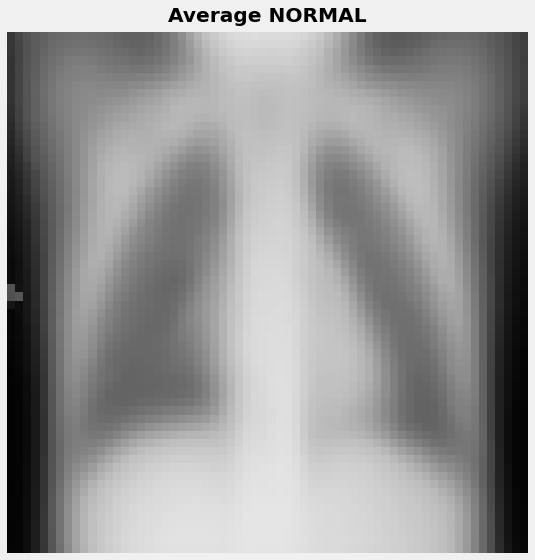

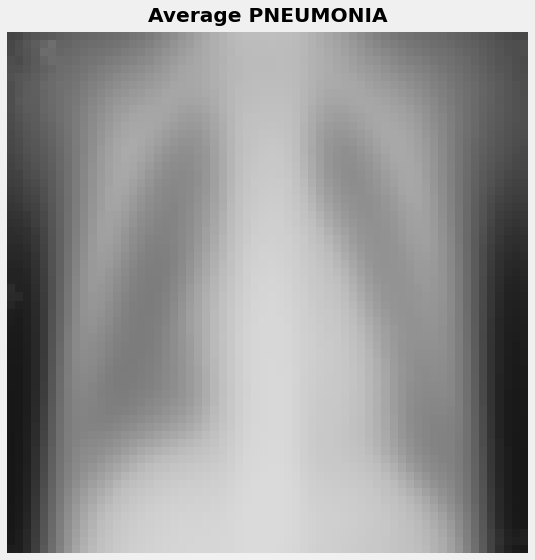

In [17]:
# finding the avearage image


def find_mean_img(full_mat, title, size=(64, 64)):
    fig = plt.figure(figsize=(8, 8))
    # calculate the average
    mean_img = np.mean(full_mat, axis=0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()

    return mean_img


norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')


An important thing to note:  We can see from the average images that pneumonia X-rays tend to show higher obstruction around the chest area.


### Contrast Between Average Images

Using the average images, we can also compute the difference.


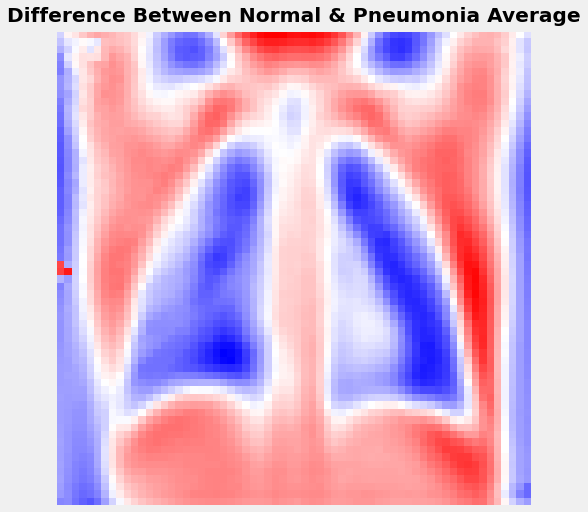

In [18]:
# obtaining the constrast between averages
contrast_mean = norm_mean - pneu_mean

# plot the differences
fig = plt.figure(figsize = (8, 8))
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()


### Variability

Similarly, we can also look at which area is most variable in either class by computing variance or standard deviation instead of the mean.  Here the lighter area indicates higher variability.


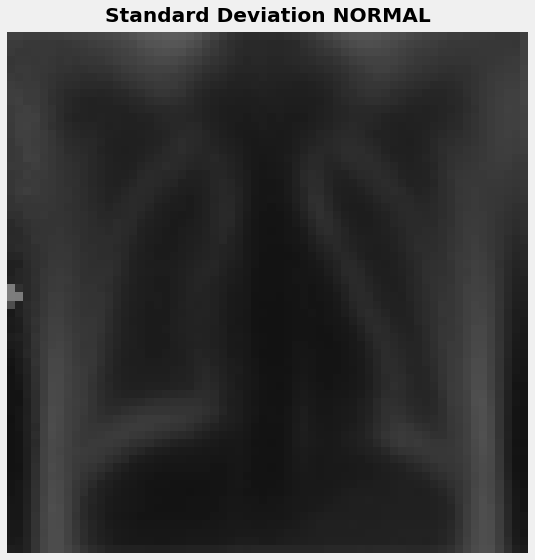

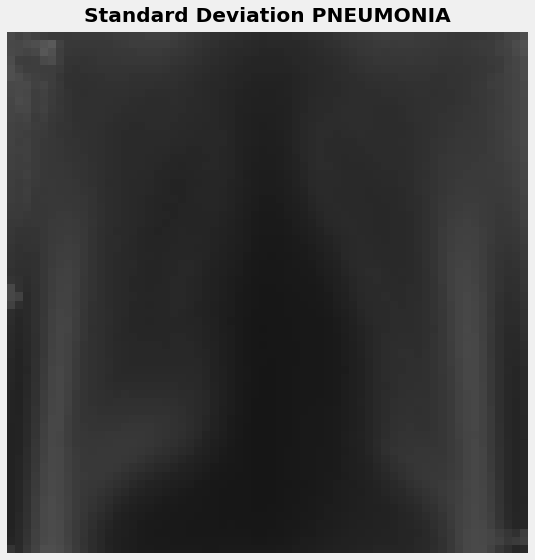

In [19]:
# plot variability


def find_std_dev_img(full_mat, title, size=(64, 64)):
    fig = plt.figure(figsize=(8, 8))
    # calculate the standard deviation
    std_dev_img = np.std(full_mat, axis=0)
    # reshape it back to a matrix
    std_dev_img = std_dev_img.reshape(size)
    plt.imshow(std_dev_img, vmin=0, vmax=255, cmap="Greys_r")
    plt.title(f"Standard Deviation {title}")
    plt.axis("off")
    plt.show()
    return std_dev_img


norm_std = find_std_dev_img(normal_images, "NORMAL")
pneu_std = find_std_dev_img(pnemonia_images, "PNEUMONIA")


Again we can see that in pneumonia X-rays, there is more variability within the lungs.

### Eigenimages

Lastly, we can use a dimension reduction technique such as the principal component analysis (PCA) to visualize the components that describe each class the best. The eigenimages, which is essentially the eigenvectors (components) of PCA of our image matrix, can be reshaped into a matrix and be plotted.

It’s also called eigenfaces as this approach was first used for facial recognition research. Here we will visualize the principal components that describe 70% of variability for each class.


NORMAL Image
 Number of Principal Components:  28


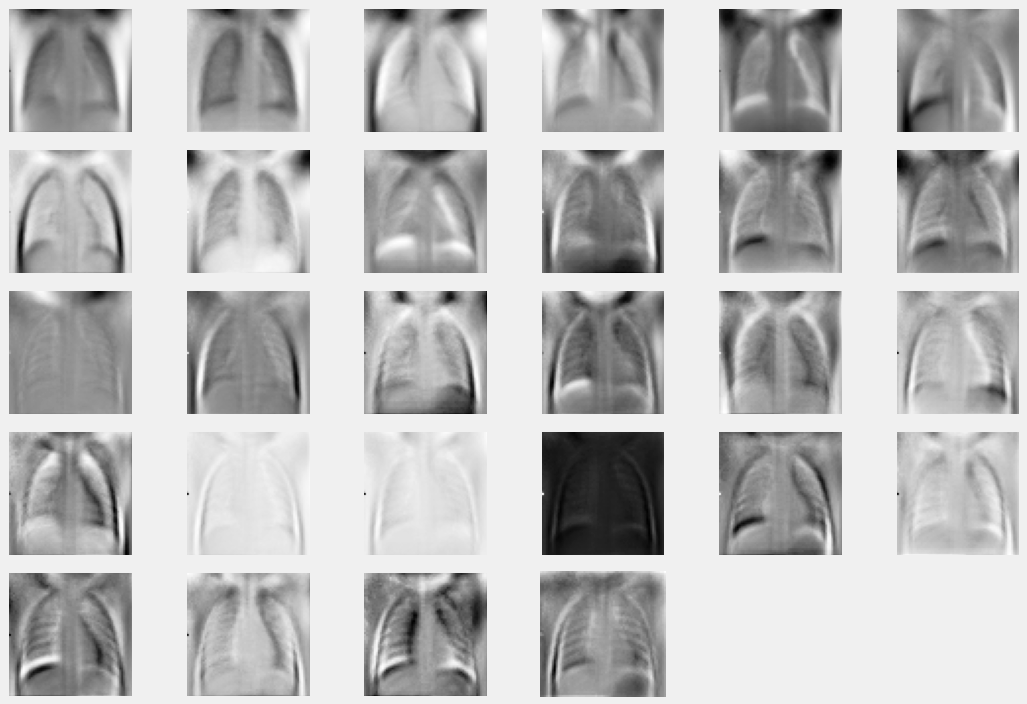

PNEUMONIA Image
 Number of Principal Components:  14


In [20]:
# create functions for eigenimages and plot it


def eigenimages(full_mat, title, n_comp=0.7, size=(64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components=n_comp, whiten=True)
    pca.fit(full_mat)
    print(f"{title} Image\n Number of Principal Components: ",
          pca.n_components_)

    return pca


def plot_pca(pca, size=(64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(15, 10))
    r = int(n ** 0.5)
    c = ceil(n / r)

    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(size), cmap="Greys_r")
    plt.axis("off")
    plt.show()


plot_pca(eigenimages(normal_images, "NORMAL"))
plot_pca(eigenimages(pnemonia_images, "PNEUMONIA"))


We can see that the eigenimages of healthy X-ray images show much more edge definitions around rib cages and organs compared to the pneumonia class.  The image classifier will be able to capture this.


### Ben Graham's Method
Let's try using Ben Graham's method. It involves using grayscale images and then applying Gaussian Blur to them later.

In [21]:
# Shuffle and Get some images into new list
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]


fig = plt.figure(figsize=(15, 10))
columns = 4
rows = 2


for i in range(1, columns * rows + 1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(
                          img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)
    plt.title("Gaussian blur")


In a Gaussian blur, the pixels nearest the center of the kernel are given more weight than those far away from the center. This averaging is done on a channel-by-channel basis, and the average channel values become the new value for the filtered pixel.  Larger kernels have more values factored into the average, and this implies that a larger kernel will blur the image more than a smaller kernel.

The goal of blurring is to perform noise reduction that's why with Graham's method we don't want to blurr the images too much, we‘ll lose the data. Therefore we need to find an adequate amount of blurring we’re going to apply without losing desirable edges.  


### Background Subtraction

Now we will use Background Subtraction Method widely used technique for generating a foreground mask.


In [22]:
background_sub = cv2.createBackgroundSubtractorMOG2()

fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = background_sub.apply(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)


As the name suggests, background subtraction calculates the foreground mask performing a subtraction between the current frame and a background model, containing the static part of the scene or, more in general, everything that can be considered as background given the characteristics of the observed scene.


### Fourier Method for Pixel Distribution

Let's use Fourier Transforms

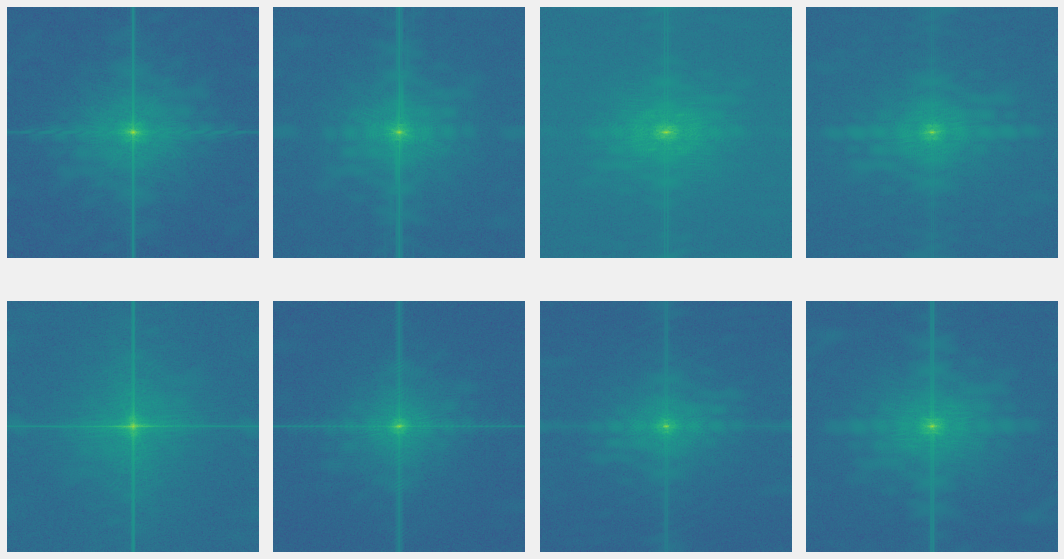

In [23]:
fig = plt.figure(figsize=(15, 10))
columns = 4
rows = 2

for i in range(1, columns*rows+1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)


You might think that it's just a bunch of blue dots, but it's more than that.

Whats happening here is that those images are basically magnitude spectrums, this helps in understanding where majority of growth is situated.

### Data Augmentation Examples using Albumentations Visualization

Let's visualize how our images will be looking after some Data Augmentation.

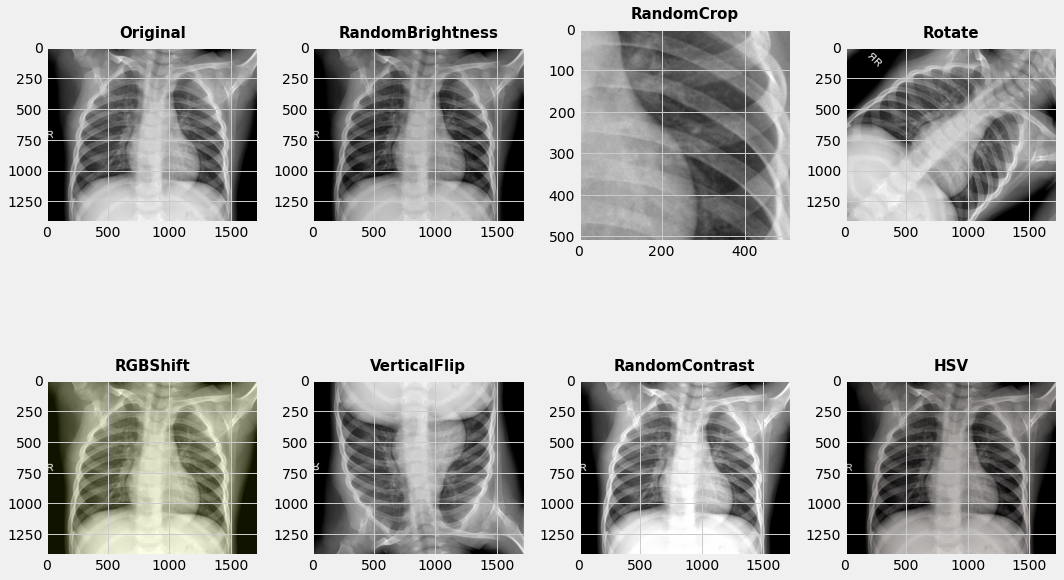

[INFO] 


In [24]:
# set a function to plot multiple augmentations


def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(15, 10), nrows=2,
                               ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize=30)
    fig.subplots_adjust(wspace=0.2)
    fig.subplots_adjust(hspace=0.2)

    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()


chosen_image = cv2.imread(images[25])

albumentation_list = [
    A.RandomBrightness(p=1),
    A.RandomCrop(p=1, height=512, width=512),
    A.Rotate(p=1, limit=90),
    A.RGBShift(p=1),
    A.VerticalFlip(p=1),
    A.RandomContrast(limit=0.5, p=1),
    A.HueSaturationValue(
        p=1, hue_shift_limit=20,
        sat_shift_limit=30,
        val_shift_limit=50,
        )
]

img_matrix_list = []
bboxes_list = []

for aug_type in albumentation_list:
    img = aug_type(image=chosen_image)["image"]
    img_matrix_list.append(img)

img_matrix_list.insert(0, chosen_image)

titles_list = [
    "Original",
    "RandomBrightness",
    "RandomCrop",
    "Rotate",
    "RGBShift",
    "VerticalFlip",
    "RandomContrast",
    "HSV",
]

plot_multiple_img(
    img_matrix_list,
    titles_list,
    ncols=4,
)
print("[INFO] ")

This could be some of augmentation type we could try for data augmentaion.  Image augmentation is used in deep learning and computer vision tasks to increase the quality of trained models.  It is also a method to prevent overfitting.  The purpose of image augmentation is to create new training samples from the existing data.


### Image Erosion

In [25]:
fig = plt.figure(figsize=(15, 10))
columns = 5
rows = 2

for i in range(1, columns*rows+1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)


### Image Dilation

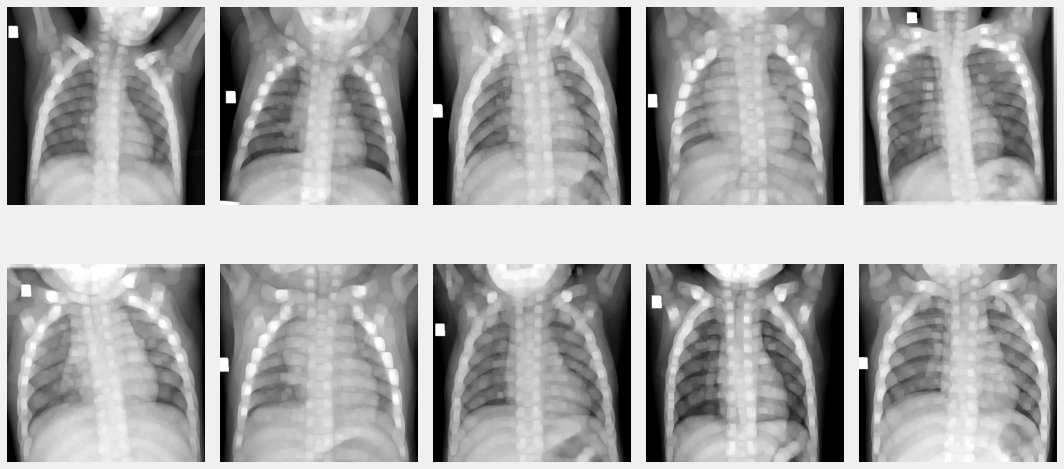

In [26]:
fig = plt.figure(figsize=(15, 10))
columns = 5
rows = 2

for i in range(1, columns*rows+1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)


### Canny Edge Detection

Canny Edge Detection is a popular edge detection algorithm.  One of it main aspects is to help with noise reduction, finding the intensity gradient of the image, suppresion (non-maximum supression) and as well as hysterisis thresholding which decides which part of the image are all edges, really edges and which are not.


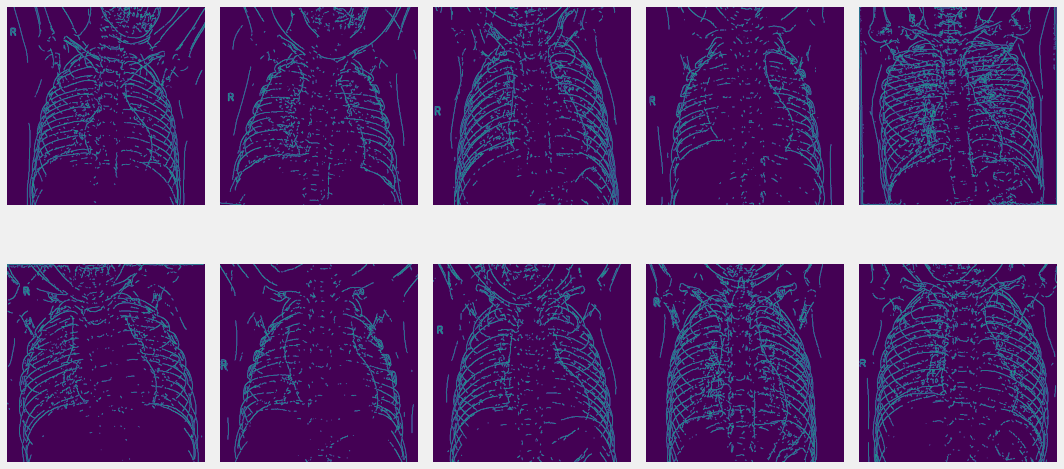

In [27]:
fig = plt.figure(figsize=(15, 10))
columns = 5
rows = 2

for i in range(1, columns*rows+1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)


# References


1. https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

2.  https://docs.opencv.org/3.4/da/dd0/tutorial_table_of_content_video.html